## Contexte

La courbe d'apprentissage du CNN semble maintenant vouloir converger vers un maximum mais on ne peut pas encore l'affirmer : Il est donc nécessaire de continuer l'apprentissage.

Pour la phase d'entrainement, la courbe d'apprentissage est légèrement en deça de la courbe d'apprentissage de la phase de validation : il est donc souhaitable d'améliorer cela afin de permet un apprentissage plus rapide du CNN.

Une fois que la convergence de la courbe d'apprentissage sera vers le maximum, il serait bien d'approcher au maximum le point de perte minimale du CNN afin d'optimiser la fonction coût.

## Objectif

Pour essayer d'otimiser l'apprentissage du CNN, les couches Dropout vont être modifiées pour essayer de palier à ce léger sous-entrainement.

Pour cela : 

* Le CNN précédemment entrainé va être restoré et ses poids seront sauvegardés.

* Ensuite un nouveau CNN, à l'identique du précédent à part pour les couches Dropout, va être construit est compilé.

* Pour terminer, les poids précédemment sauvegardés vont être réinjectés dans le nouveau CNN.

L'apprentissage du CNN sera ensuite réalisé pour optimiser la phase d'entrainement et pour améliorer les scores.

Pour clore cet apprentissage et quand les scores seront stabilisés vers un maximum, le hyper-paramètre learning-rate sera optimisé : cela permettra d'optimiser la fonction coût du CNN et d'approcher le score maximum que le CNN peut réellement atteindre.

In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from lib import ressources as res
racine = os.path.abspath(os.path.realpath(res.dir_root))

### Restauration du CNN pré-entrainé

In [2]:
from tensorflow import keras

path_cnn = res.dir_dataset + '_cnn_2_2.save'

classifier = keras.models.load_model(path_cnn)

epochs_start_value = 81

# valeur = 1 : pour pour un test unitaire afin de tester le code source
epochs_added = 1

### Les poids du CNN entrainé sont récupérés

In [3]:
# les poids du CNN entrainé sont récupérées
poids = classifier.get_weights()

### Construction du CNN avec modification des couches Dropout

In [4]:
# Import des librairies

# initialisation du CNN de manière séquentielle et non en graphe
from keras.models import Sequential

# les vidéos sont en 3D, on ajoute une dimension supplémentaire qui est le temps
# étape de convolution -> 2D car image
from keras.layers import Conv2D

# étape de max pooling
from keras.layers import MaxPooling2D

# étape de flatten
from keras.layers import Flatten

# couches du CNN
from keras.layers import Dense

# CNN optimization : Dropout added to avoid overfiting
from keras.layers import Dropout



In [5]:
# Le CNN est initialisé en mode séquentiel
classifier = Sequential()

# Conv2D -> couche de convolution
# Pour des raisons de limitation ressources système, les photo sont converties en 128 * 128
classifier.add(Conv2D(filters = 64, kernel_size = (3, 3), strides = 1, input_shape = (128, 128, 3), activation = 'relu'))

# couche : Max pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Conv2D -> couche de convolution
classifier.add(Conv2D(filters = 32, kernel_size = (3, 3), strides = 1, activation = 'relu'))

# couche : Max pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Couche : Flattening
classifier.add(Flatten())

# Couche : Full connection
classifier.add(Dense(units = 128, activation = 'relu'))

# Modification de la couche Dropout
classifier.add(Dropout(0.2))

# Couche : Full connection
classifier.add(Dense(units = 64, activation = 'relu'))

# Modification de la couche Dropout
classifier.add(Dropout(0.2))

# Couche de sortie
classifier.add(Dense(units = 38, activation = 'softmax'))

# compilation du CNN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

### Les poids sont réinjectés dans le CNN modifié

In [6]:
classifier.set_weights(poids)

## Entrainement 1 du CNN

In [7]:
# entrainement du CNN

# augmentation du jeu d'images
from keras.preprocessing.image import ImageDataGenerator


# préparation du traitement de génération de nouvelles images pour le jeu d'entrainement
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# préparation du traitement de génération de nouvelles images pour le jeu de test : l'échelle des valeurs est normalisées
test_datagen = ImageDataGenerator(rescale = 1./255)

# traitement des images du jeu d'entrainement
training_set = train_datagen.flow_from_directory(res.dir_dataset_train,
                                                 target_size = (128, 128),
                                                 batch_size = 280,
                                                 class_mode = 'categorical')

# traitement des images du jeu de test
test_set = test_datagen.flow_from_directory(res.dir_dataset_valid,
                                            target_size = (128, 128),
                                            batch_size = 70,
                                            class_mode = 'categorical')

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [8]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_step = test_set.n // test_set.batch_size

# fit_generator -> entraine le CNN et effectue le test aussi et mesure la performance
training_history = classifier.fit_generator(training_set,
                         steps_per_epoch = steps_per_epoch,
                         epochs = epochs_added,
                         validation_data = test_set,
                         validation_steps = validation_step)
                         

Instructions for updating:
Please use Model.fit, which supports generators.
251/251 [==============================] - 1537s 6s/step - loss: 0.2102 - accuracy: 0.9325 - val_loss: 0.2039 - val_accuracy: 0.9344


## Estimation 1 du CNN

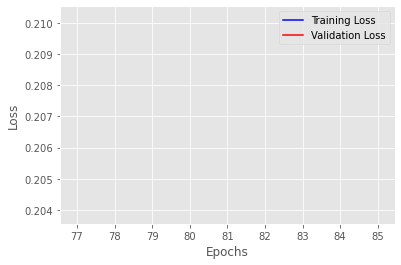

In [9]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
%matplotlib inline

plt.style.use("ggplot")

# Labels des axes
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Courbe de la perte sur l'échantillon d'entrainement
plt.plot(np.arange(epochs_start_value , epochs_start_value + epochs_added, 1),
         training_history.history['loss'],
         label = 'Training Loss',
         color = 'blue')

# Courbe de la perte sur l'échantillon de validation
plt.plot(np.arange(epochs_start_value , epochs_start_value + epochs_added, 1),
         training_history.history['val_loss'], 
         label = 'Validation Loss',
         color = 'red')

# Affichage de la légende
plt.legend()

# Affichage de la figure
plt.show()

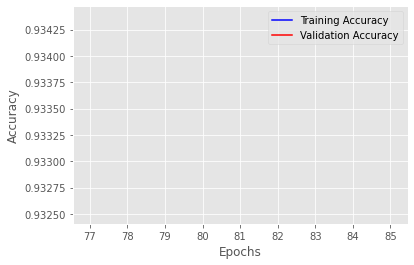

In [10]:
# Labels des axes
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Courbe de précision sur l'échantillon d'entrainement
plt.plot(np.arange(epochs_start_value , epochs_start_value + epochs_added, 1),
         training_history.history['accuracy'],
         label = 'Training Accuracy',
         color = 'blue')

# Courbe de précision sur l'échantillon de validation
plt.plot(np.arange(epochs_start_value , epochs_start_value + epochs_added, 1),
         training_history.history['val_accuracy'], 
         label = 'Validation Accuracy',
         color = 'red')

# Affichage de la légende
plt.legend()

# Affichage de la figure
plt.show()

### Sauvegarde du CNN

In [11]:
# sauvegarde du CNN

path_cnn = res.dir_dataset + '_cnn_2_3.save'
# print(path_cnn)

classifier.save(path_cnn);

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\NOEL\dev\python\dataset\new-plant-diseases-dataset_cnn_2_3.save\assets


In [12]:
# les poids du CNN entrainé sont récupérées
poids_2 = classifier.get_weights()

## Optimisation du hyper-paramètre Learning Rate

In [17]:
# un nouvel entrainement va être réalisé
total_epochs_added = epochs_added

# valeur = 1 : pour pour un test unitaire afin de tester le code source
epochs_added = 1
total_epochs_added += epochs_added

2


In [14]:
# Le CNN est initialisé en mode séquentiel
classifier = Sequential()

# Conv2D -> couche de convolution
# Pour des raisons de limitation ressources système, les photo sont converties en 128 * 128
classifier.add(Conv2D(filters = 64, kernel_size = (3, 3), strides = 1, input_shape = (128, 128, 3), activation = 'relu'))

# couche : Max pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Conv2D -> couche de convolution
classifier.add(Conv2D(filters = 32, kernel_size = (3, 3), strides = 1, activation = 'relu'))

# couche : Max pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Couche : Flattening
classifier.add(Flatten())

# Couche : Full connection
classifier.add(Dense(units = 128, activation = 'relu'))

# Modification de la couche Dropout
classifier.add(Dropout(0.2))

# Couche : Full connection
classifier.add(Dense(units = 64, activation = 'relu'))

# Modification de la couche Dropout
classifier.add(Dropout(0.2))

# Couche de sortie
classifier.add(Dense(units = 38, activation = 'softmax'))

# le hyper-parmètre Learning rate est modifié
opt = keras.optimizers.Adam(learning_rate=0.01)

# compilation du CNN
classifier.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# récupération des poids du CNN entrainé
classifier.set_weights(poids_2)

## Entrainement 2 du CNN

In [15]:

# fit_generator -> entraine le CNN et effectue le test aussi et mesure la performance
training_history = classifier.fit_generator(training_set,
                         steps_per_epoch = steps_per_epoch,
                         epochs = epochs_added,
                         validation_data = test_set,
                         validation_steps = validation_step)
                         

251/251 [==============================] - 1374s 5s/step - loss: 3.2828 - accuracy: 0.2548 - val_loss: 1.4885 - val_accuracy: 0.5462
